# Data validation and primary/correspondence authors checking

Danilo Lessa Bernardineli (danilo.bernardineli@usp.br)

On this notebook, I want to accomplish the following tasks:

1. Validate the mining result data against the summarized metrics on wer_usp.
    * How does the total article count compares with the metrics on wer_usp for all sources?
    * How does the citation count compares?
2. Analyze the primary and correspondence authors on the collected dataset
    * What is the proportion of the ICB authors who are primary and correspondence authors?
    * How do they compare with other institutes?

## Dependences and loadings

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os
import json

In [17]:
# Filepath for the datasets
scopus_filepath = "data/scopus.xls"
wer_filepath = "data/wer_usp.csv"

In [18]:
scopus_data = pd.read_excel(scopus_filepath).drop_duplicates().drop(columns=['Unnamed: 0'])
wer_data = pd.read_csv(wer_filepath)

In [100]:
journal_impact_path = Path("data/journal_impact")

In [101]:
impact_files = [journal_impact_path / file for file in os.listdir(str(journal_impact_path)) if file[-5:] == ".json"]

In [112]:
impact_list = []
for file in impact_files:
    with open(str(file), 'r') as fid:
        text = fid.read()
        it_data = pd.DataFrame(json.loads(text)['data'])
        impact_list.append(it_data)

In [113]:
impact_data = pd.concat(impact_list)

##  Data  validation

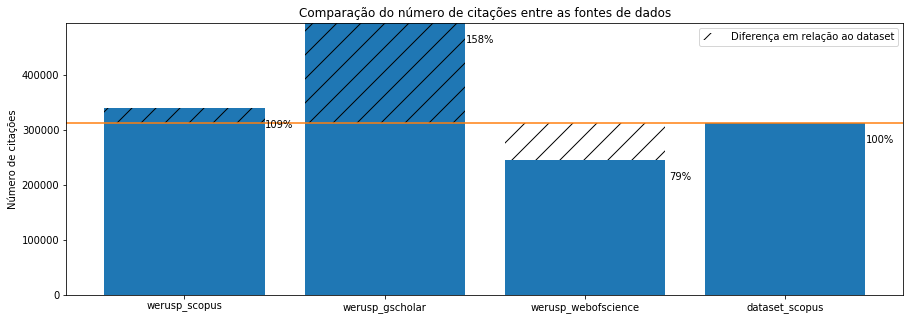

In [19]:
base_count = scopus_data.citedby_count.sum()

citation_dict = {"werusp_scopus": wer_data.citacoesScopus.sum(),
                 "werusp_gscholar": wer_data.citacoesGoogleScholar.sum(),
                 "werusp_webofscience": wer_data.citacoesWos.sum(),
                 "dataset_scopus": scopus_data.citedby_count.sum()}

plt.figure(figsize=(15, 5))
N = len(citation_dict)
ind = np.arange(N)

x = [val for val in citation_dict.values()]

plt.bar(ind, x)
plt.bar(ind, [base_count - c for c in x],
        bottom=x, hatch='/', color='C2',
        alpha=0, tick_label=x, label='Diferença em relação ao dataset')
for x_i, y_i in zip(ind, x):
    label = "{:.0%}".format(y_i / base_count)
    plt.annotate(label, # this is the text
                 (x_i, y_i), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(95, -20), # distance from text to points (x,y)
                 ha='center')
plt.axhline(base_count, color='C1')
plt.xticks(ind, citation_dict.keys())
plt.title("Comparação do número de citações entre as fontes de dados")
plt.ylabel("Número de citações")
plt.legend()
plt.show()

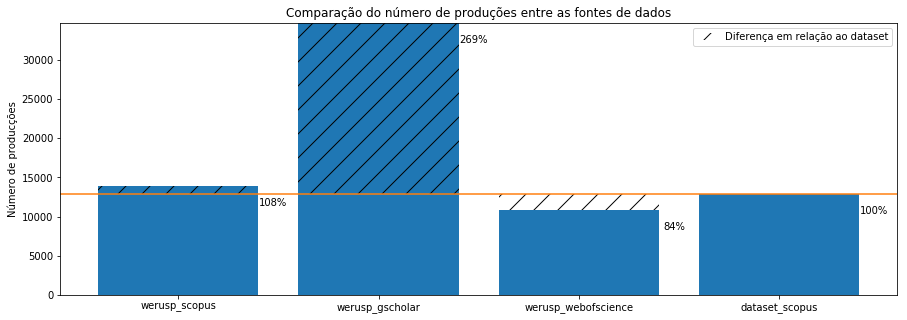

In [20]:
base_count = scopus_data.eid.count()
citation_dict = {"werusp_scopus": wer_data.documentoScopus.sum(),
                 "werusp_gscholar": wer_data.documentoGoogleScholar.sum(),
                 "werusp_webofscience": wer_data.documentoWoS.sum(),
                 "dataset_scopus": base_count}
plt.figure(figsize=(15, 5))
N = len(citation_dict)
ind = np.arange(N)
x_k = [val for val in citation_dict.keys()]
x = [val for val in citation_dict.values()]
plt.bar(ind, x)
plt.bar(ind, [base_count - c for c in x],
        bottom=x, hatch='/', color='C2',
        alpha=0, tick_label=x, label='Diferença em relação ao dataset')

for x_i, y_i in zip(ind, x):
    label = "{:.0%}".format(y_i / base_count)
    plt.annotate(label, # this is the text
                 (x_i, y_i), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(95, -20), # distance from text to points (x,y)
                 ha='center')

plt.axhline(base_count, color='C1')
plt.title("Comparação do número de produções entre as fontes de dados")
plt.ylabel("Número de producções")
plt.xticks(ind, citation_dict.keys())
plt.legend()
plt.show()

## Author precedence

In [21]:
primary_authors = scopus_data.author_ids.astype(str).str.split(";").map(lambda x: x[0].strip())
last_authors = scopus_data.author_ids.astype(str).str.split(";").map(lambda x: x[-1].strip())
author_count = scopus_data.author_ids.astype(str).str.split(";").map(lambda x: len(x))

author_dict = {"primary_author_id": primary_authors,
               "last_author_id": last_authors,
               "author_count": author_count}

author_data = pd.DataFrame(author_dict)

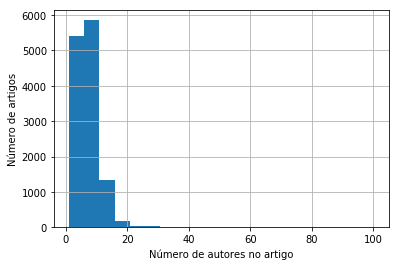

In [25]:
author_data.author_count.hist(bins=20)
plt.ylabel("Número de artigos")
plt.xlabel("Número de autores no artigo")
plt.show()

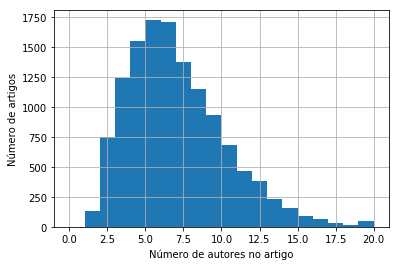

In [26]:
author_data.author_count.hist(bins=20, range=(0, 20))
plt.ylabel("Número de artigos")
plt.xlabel("Número de autores no artigo")
plt.show()

## Author count

In [31]:
scopus_map = wer_data.loc[:, ['idScopus', 'codpesOfuscado']].set_index('idScopus')

In [53]:
one_author_data = author_data.where(author_data.author_count == 1).dropna()
one_author_data.size

417

In [54]:
two_author_data = author_data.where(author_data.author_count == 2).dropna()

inds = two_author_data.primary_author_id.isin(scopus_map.index)
inds &= two_author_data.last_author_id.isin(scopus_map.index)
icb_two_author_data = two_author_data[inds]

Categories:

1. articles with 1 or 2+ ICB authors (primary OR last)
2. remaining articles

In [61]:
one_author_inds = (author_data.author_count == 1)

two_authors_inds = (author_data.author_count == 2)

three_plus_author_inds = author_data.last_author_id.isin(scopus_map.index)
three_plus_author_inds |= author_data.primary_author_id.isin(scopus_map.index)
three_plus_author_inds &= (author_data.author_count > 2)

cat1_inds = one_author_inds | two_authors_inds | three_plus_author_inds
cat1_data = author_data[cat1_inds]
cat2_data = author_data[~cat1_inds]

In [140]:
scopus_data.iloc[0].T

eid                                                   2-s2.0-85026795152
doi                                          10.1152/ajprenal.00557.2016
pii                                                                  NaN
pubmed_id                                                    2.84905e+07
title                  The effects of angiotensin-(1-7) on the exchan...
subtype                                                               ar
creator                                                Castelo-Branco R.
afid                                                            60008088
affilname                                Universidade de Sao Paulo - USP
affiliation_city                                               Sao Paulo
affiliation_country                                               Brazil
author_count                                                           5
author_names           Castelo-Branco, Regiane Cardoso;Leite-Dellova,...
author_ids             55756878100;25825176000;2357

In [142]:
cols = ['eid', 'citedby_count', 'publicationName', 'author_names', 'coverDate']
new_scopus_data = (scopus_data.loc[:, cols]
                              .copy()
                              .assign(coverDate=lambda df: pd.to_datetime(df.coverDate))
                              .assign(coverYear=lambda df: df.coverDate.dt.year))

new_scopus_data.loc[cat1_inds, 'category'] = 1
new_scopus_data.loc[~cat1_inds, 'category'] = 2
new_scopus_data.to_csv("categorized_scopus_data.csv")

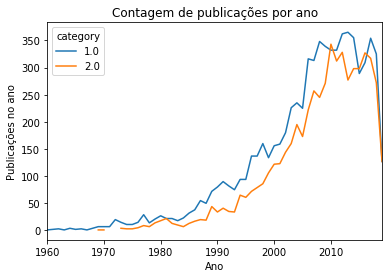

In [166]:
new_scopus_data.groupby(['coverYear', 'category']).eid.count().unstack().plot()
plt.title("Contagem de publicações por ano")
plt.ylabel("Publicações no ano")
plt.xlabel("Ano")

plt.show()

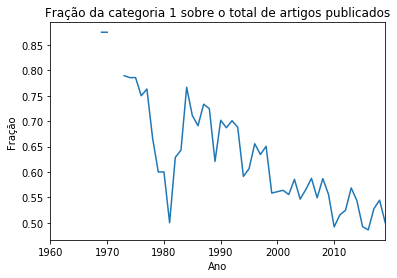

In [165]:
new_scopus_data.groupby(['coverYear', 'category']).eid.count().unstack().apply(lambda x: x[1] / (x[1] + x[2]), axis=1).plot()
plt.title("Fração da categoria 1 sobre o total de artigos publicados")
plt.ylabel("Fração")
plt.xlabel("Ano")

plt.show()

In [199]:
cols = ['nompes',
        'nomeDepto',
        'programaPos',
        'areaProdutividade',
        'bolsa',
        'totalMestrado',
        'totalDoutorado',
        'citacoesGoogleScholar',
        'citacoesScopus',
        'citacoesWos',
        'indicehGoogleScholar',
        'indicehScopus',
        'indicehWoS']

In [201]:
wer_data.loc[:, cols].to_csv("docentes_wer_usp.csv")

In [182]:
wer_data.columns

Index(['codpesOfuscado', 'nompes', 'areaProdutividade', 'bolsa', 'nomeDepto',
       'programaPos', 'anoFimCredenciamento', 'anoInicioCredenciamento',
       'citacoesGoogleScholar', 'citacoesGoogleScholarPeriodo',
       'citacoesScopus', 'citacoesScopusPeriodo', 'citacoesWos',
       'citacoesWosPeriodo', 'codpes', 'documentoGoogleScholar',
       'documentoScopus', 'documentoWoS', 'idLattes', 'idOrcid',
       'idResearcherID', 'idScholar', 'idScopus', 'indicehGoogleScholar',
       'indicehScopus', 'indicehWoS', 'Unnamed: 26', 'totalComColabInterPerc',
       'totalDoutorado', 'totalEstratoA1', 'totalEstratoA2', 'totalEstratoB1',
       'totalEstratoB2', 'totalEstratoB3', 'totalEstratoB4', 'totalEstratoB5',
       'totalEstratoC', 'totalMestrado', 'totalProdComColabInter',
       'totalProducoes', 'codigoProgramaPos', 'anoFimCredenciamento_grad',
       'anoInicioCredenciamento_grad', 'areaProdutividade_grad', 'bolsa_grad',
       'citacoesGoogleScholar_grad', 'citacoesGoogleSchola

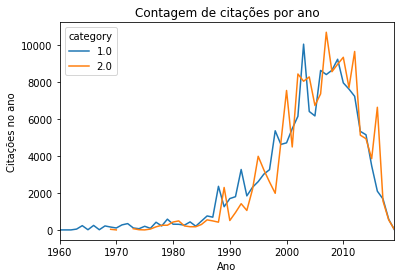

In [164]:
new_scopus_data.groupby(['coverYear', 'category']).citedby_count.sum().unstack().plot()
plt.title("Contagem de citações por ano")
plt.ylabel("Citações no ano")
plt.xlabel("Ano")

plt.show()

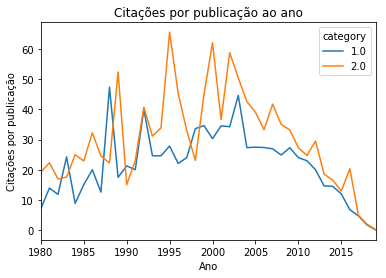

In [176]:
new_scopus_data[new_scopus_data.coverDate > "1980"].groupby(['coverYear', 'category']).citedby_count.agg(['sum', 'count']).apply(lambda x: x['sum'] / x['count'], axis=1).unstack().plot()
plt.title("Citações por publicação ao ano")
plt.ylabel("Citações por publicação")
plt.xlabel("Ano")

plt.show()

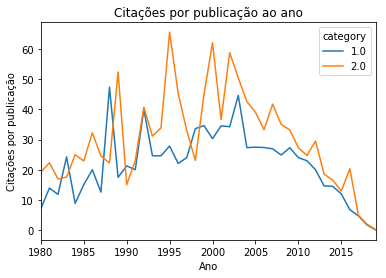

In [175]:
new_scopus_data[new_scopus_data.coverDate > "1980"].groupby(['coverYear', 'category']).citedby_count.agg(['sum', 'count']).apply(lambda x: x['sum'] / x['count'], axis=1).unstack().plot()
plt.title("Citações por publicação ao ano")
plt.ylabel("Citações por publicação")
plt.xlabel("Ano")

plt.show()

In [32]:
effective_author_data = author_data.where(author_data.author_count > 2).dropna()

In [33]:
scopus_map.index.intersection(effective_author_data.primary_author_id).size

1574

In [34]:
scopus_map.index.intersection(effective_author_data.primary_author_id).size / len(effective_author_data)

0.1308395677472984

In [35]:
scopus_map.index.intersection(effective_author_data.last_author_id).size

5172

In [36]:
scopus_map.index.intersection(effective_author_data.last_author_id).size / len(effective_author_data)

0.42992518703241894

In [37]:
len(effective_author_data)

12030